# DIALOGUE

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pertpy as pt
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import pickle as pkl

In [3]:
adata = ad.read_h5ad("zhang.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 489490 × 27085
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'

## TG preprocessing

In [5]:
adata = adata[adata.obs['Origin']=="t" ,:].copy()

In [6]:
adata = adata[adata.obs['Sample'].str.contains('Pre'),:].copy()
adata

AnnData object with n_obs × n_vars = 89219 × 27085
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'

In [7]:
sc.pp.filter_genes(adata, min_cells=10)

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor = "seurat_v3")

In [11]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [12]:
sc.pp.scale(adata, max_value=10)

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

## Now TG pre DLG

In [14]:
isecs = pd.crosstab(adata.obs['Cluster'], adata.obs['Sample'])

In [15]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]]

Sample,Pre_P002_t,Pre_P004_t,Pre_P005_t,Pre_P007_t,Pre_P010_t,Pre_P012_t,Pre_P013_t,Pre_P016_t,Pre_P017_t,Pre_P018_t,Pre_P019_t,Pre_P020_t,Pre_P022_t,Pre_P023_t,Pre_P025_t
Cluster,,,,,,,,,,,,,,,
t_pB-IGHG1,679,8,12,12,4,301,4,136,14,238,1753,911,1083,206,283


In [16]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]-1]

Sample,Pre_P002_t,Pre_P004_t,Pre_P005_t,Pre_P007_t,Pre_P010_t,Pre_P012_t,Pre_P013_t,Pre_P016_t,Pre_P017_t,Pre_P018_t,Pre_P019_t,Pre_P020_t,Pre_P022_t,Pre_P023_t,Pre_P025_t
Cluster,,,,,,,,,,,,,,,
t_CD4_Tcm-LMNA,4,392,569,249,0,288,6,311,20,134,555,77,593,444,87
t_CD4_Treg-FOXP3,13,338,110,62,0,464,24,419,17,518,769,743,398,122,130
t_CD8_Tem-GZMK,8,957,368,72,0,417,17,176,21,154,2354,202,709,891,292
t_Tn-LEF1,11,98,110,3494,0,1269,22,50,609,167,4010,175,1501,388,271


In [17]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]-2]

Sample,Pre_P002_t,Pre_P004_t,Pre_P005_t,Pre_P007_t,Pre_P010_t,Pre_P012_t,Pre_P013_t,Pre_P016_t,Pre_P017_t,Pre_P018_t,Pre_P019_t,Pre_P020_t,Pre_P022_t,Pre_P023_t,Pre_P025_t
Cluster,,,,,,,,,,,,,,,
t_Bmem-CD27,377,11,12,105,0,1950,0,11,166,22,4210,132,309,121,400
t_CD8_MAIT-KLRB1,0,51,1244,45,0,40,7,84,24,19,67,14,38,20,11
t_CD8_Trm-ZNF683,3,76,180,71,0,143,4,407,4,226,422,121,449,219,150
t_mono-FCN1,4,60,11,12,0,14,23,44,1,31,43,15,51,33,16


In [18]:
celltypes = isecs[(isecs > 3).sum(axis=1) >= np.shape(isecs)[1]-2].index.values.tolist()

In [19]:
adata = adata[adata.obs['Cluster'].isin(celltypes),:].copy()
adata

AnnData object with n_obs × n_vars = 44636 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [20]:
isecs = pd.crosstab(adata.obs['Cluster'], adata.obs['Sample'])

In [21]:
keep_pts = isecs.loc[:,(isecs > 3).sum(axis=0) == isecs.shape[0]].columns.values.tolist()

In [22]:
adata = adata[adata.obs['Sample'].isin(keep_pts),:].copy()

In [23]:
pd.crosstab(adata.obs['Cluster'], adata.obs['Sample']).min(axis=1)

Cluster
t_Bmem-CD27         11
t_CD4_Tcm-LMNA      77
t_CD4_Treg-FOXP3    62
t_CD8_MAIT-KLRB1    11
t_CD8_Tem-GZMK      72
t_CD8_Trm-ZNF683    71
t_Tn-LEF1           50
t_mono-FCN1         11
t_pB-IGHG1           8
dtype: int64

In [24]:
pd.crosstab(adata.obs['Cluster'], adata.obs['Sample']).min(axis=0)

Sample
Pre_P004_t     8
Pre_P005_t    11
Pre_P007_t    12
Pre_P012_t    14
Pre_P016_t    11
Pre_P018_t    19
Pre_P019_t    43
Pre_P020_t    14
Pre_P022_t    38
Pre_P023_t    20
Pre_P025_t    11
dtype: int64

In [25]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [26]:
# sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [27]:
adata_plot = sc.pp.subsample(adata,  n_obs=10000, random_state=0, copy=True)

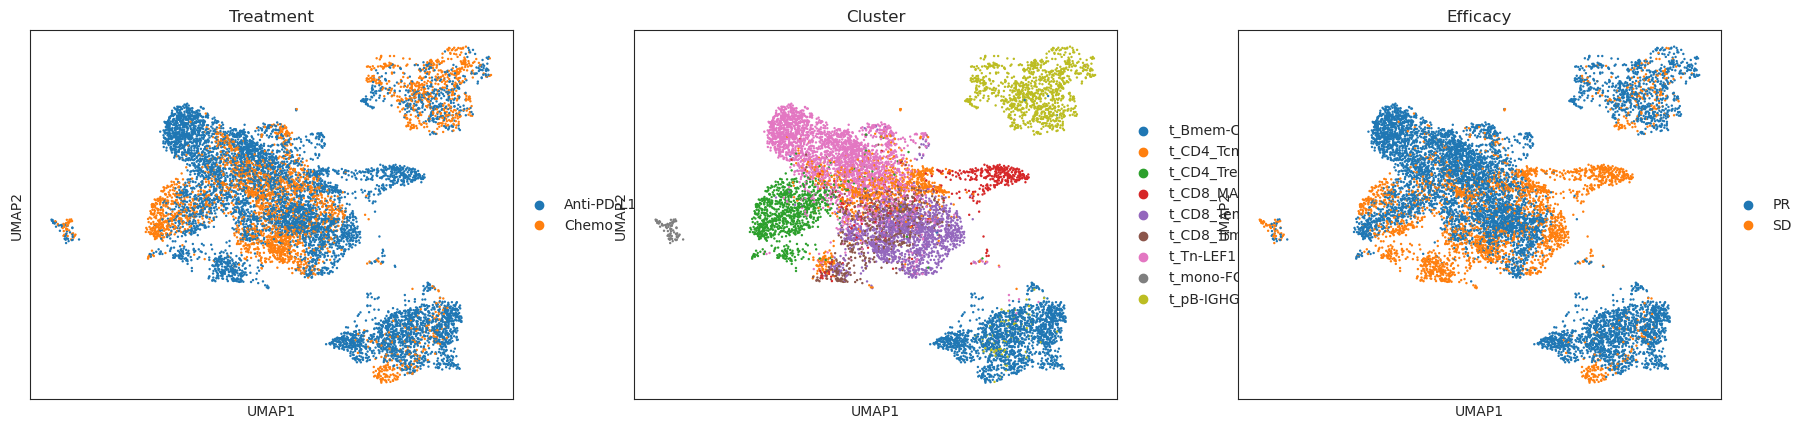

In [28]:
sc.pl.umap(
    adata_plot,
    color=[
        "Treatment",
        "Cluster",
        "Efficacy"
    ],
)

## Run DIALOGUE

### LP solver

In [29]:
adata_lp = adata.copy()

In [30]:
# necessary to ensure that the petsy doesn't complain and scikit-learn neither
adata_lp.obs.rename(columns={"Number of counts": "n_counts"}, inplace=True)
adata_lp.obs['n_counts'] = adata_lp.obs['n_counts'].str.replace(',', '').str.strip().astype(float)

In [31]:
dl_lp = pt.tl.Dialogue(sample_id = "Sample",
                       celltype_key = "Cluster",
                       n_counts_key = "n_counts",
                       n_mpcs = 10)

adata_lp, mcps_lp, ws_lp, ct_subs_lp = dl_lp.calculate_multifactor_PMD(
    adata_lp,
    normalize=True,
    solver="lp"
)

In [32]:
lp_test_results = dl_lp.test_association(adata_lp, condition_label="Efficacy")

In [33]:
pvals_lp = lp_test_results["pvals"]

In [34]:
pvals_lp.min()

mcp_0    0.235494
mcp_1    0.024989
mcp_2    0.336356
mcp_3    0.246226
mcp_4    0.055116
mcp_5    0.445057
mcp_6    0.048309
mcp_7    0.170504
mcp_8    0.228950
mcp_9    0.029985
dtype: float64

In [35]:
tstats_lp = lp_test_results["tstats"]

In [36]:
pvals_adj = lp_test_results["pvals_adj"]

In [37]:
dlg_dict = {"mcps":mcps_lp, "ws":ws_lp,"ct_subs":ct_subs_lp, "pvals":pvals_lp, "pvals_adj": pvals_adj, "tstats":tstats_lp}
outfile =  "dialogue_lp.pkl"
with open(outfile, 'wb') as pickle_file:
    pkl.dump(dlg_dict, pickle_file)
pickle_file.close()

In [49]:
adata_lp.write_h5ad("dialogue_lp.h5ad")

: 

### BS solver

In [38]:
adata_bs = adata.copy()

In [39]:
# necessary to ensure that the petsy doesn't complain and scikit-learn neither
adata_bs.obs.rename(columns={"Number of counts": "n_counts"}, inplace=True)
adata_bs.obs['n_counts'] = adata_bs.obs['n_counts'].str.replace(',', '').str.strip().astype(float)

In [40]:
dl_bs = pt.tl.Dialogue(sample_id = "Sample",
                   celltype_key = "Cluster",
                   n_counts_key = "n_counts",
                   n_mpcs = 10)

adata_bs, mcps_bs, ws_bs, ct_subs_bs = dl_bs.calculate_multifactor_PMD(
    adata_bs,
    normalize=True,
    solver="bs"
)

bs_test_results = dl_bs.test_association(adata_bs, condition_label="Efficacy")

In [41]:
pvals_bs = bs_test_results["pvals"]

In [42]:
pvals_bs.min()

mcp_0    0.061321
mcp_1    0.126744
mcp_2    0.158583
mcp_3    0.464189
mcp_4    0.305344
mcp_5    0.009987
mcp_6    0.444476
mcp_7    0.095654
mcp_8    0.547486
mcp_9    0.116495
dtype: float64

In [43]:
pvals_adj = bs_test_results["pvals_adj"]

In [44]:
tstats_bs = bs_test_results["tstats"]

In [45]:
dlg_dict = {"mcps":mcps_bs, "ws":ws_bs,"ct_subs":ct_subs_bs, "pvals":pvals_bs, "pvals_adj": pvals_adj, "tstats":tstats_bs}
outfile =  "dialogue_bs.pkl"
with open(outfile, 'wb') as pickle_file:
    pkl.dump(dlg_dict, pickle_file)
pickle_file.close()

In [46]:
adata_bs.write_h5ad("dialogue_bs.h5ad")

## Visualizations

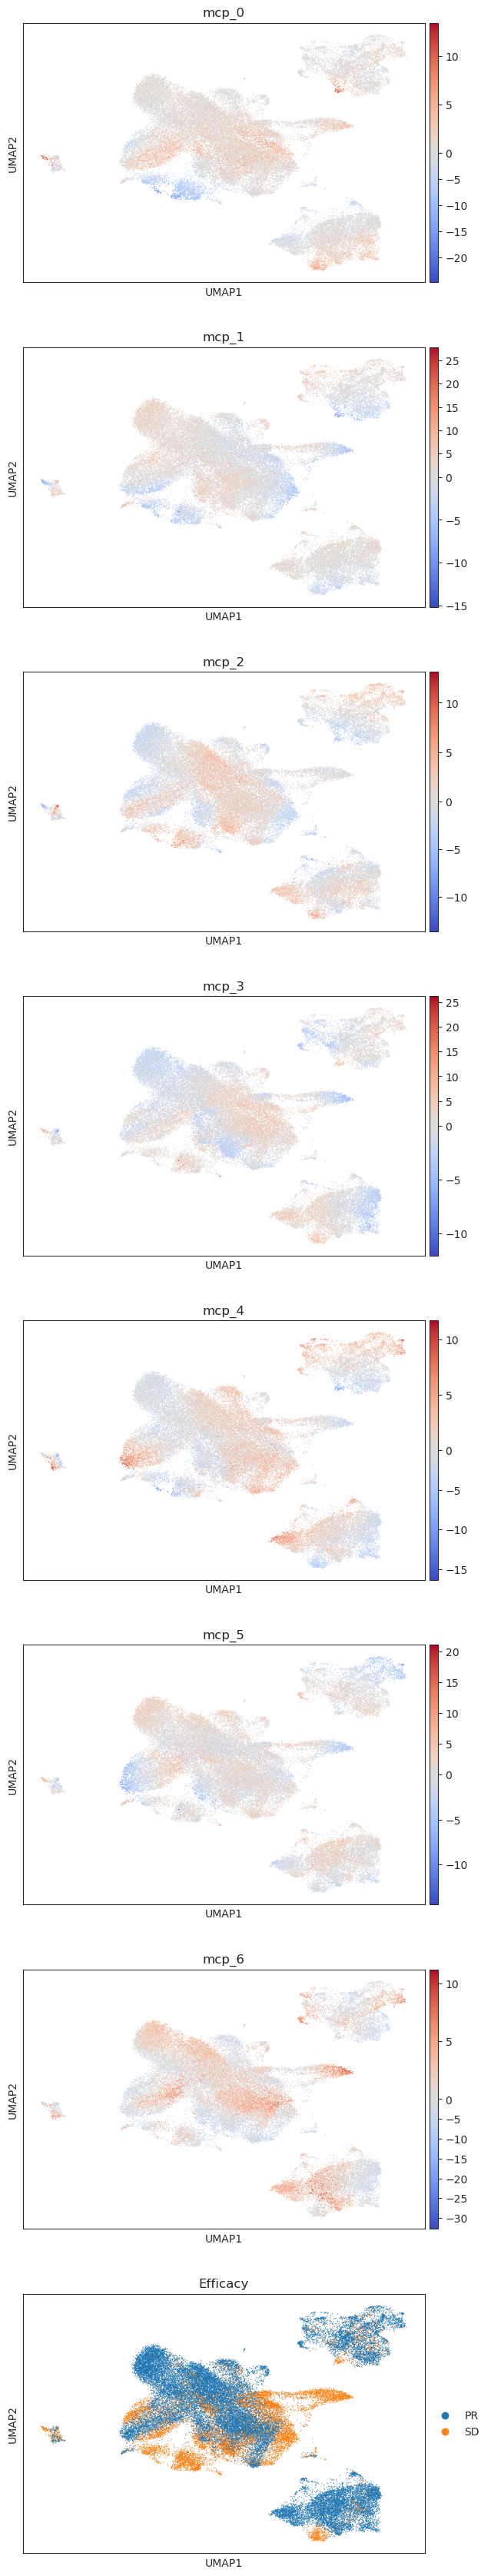

In [47]:
sc.pl.umap(adata_lp, color=["mcp_0", "mcp_1", "mcp_2","mcp_3","mcp_4","mcp_5","mcp_6","Efficacy"], ncols=1, cmap='coolwarm', vcenter=0)

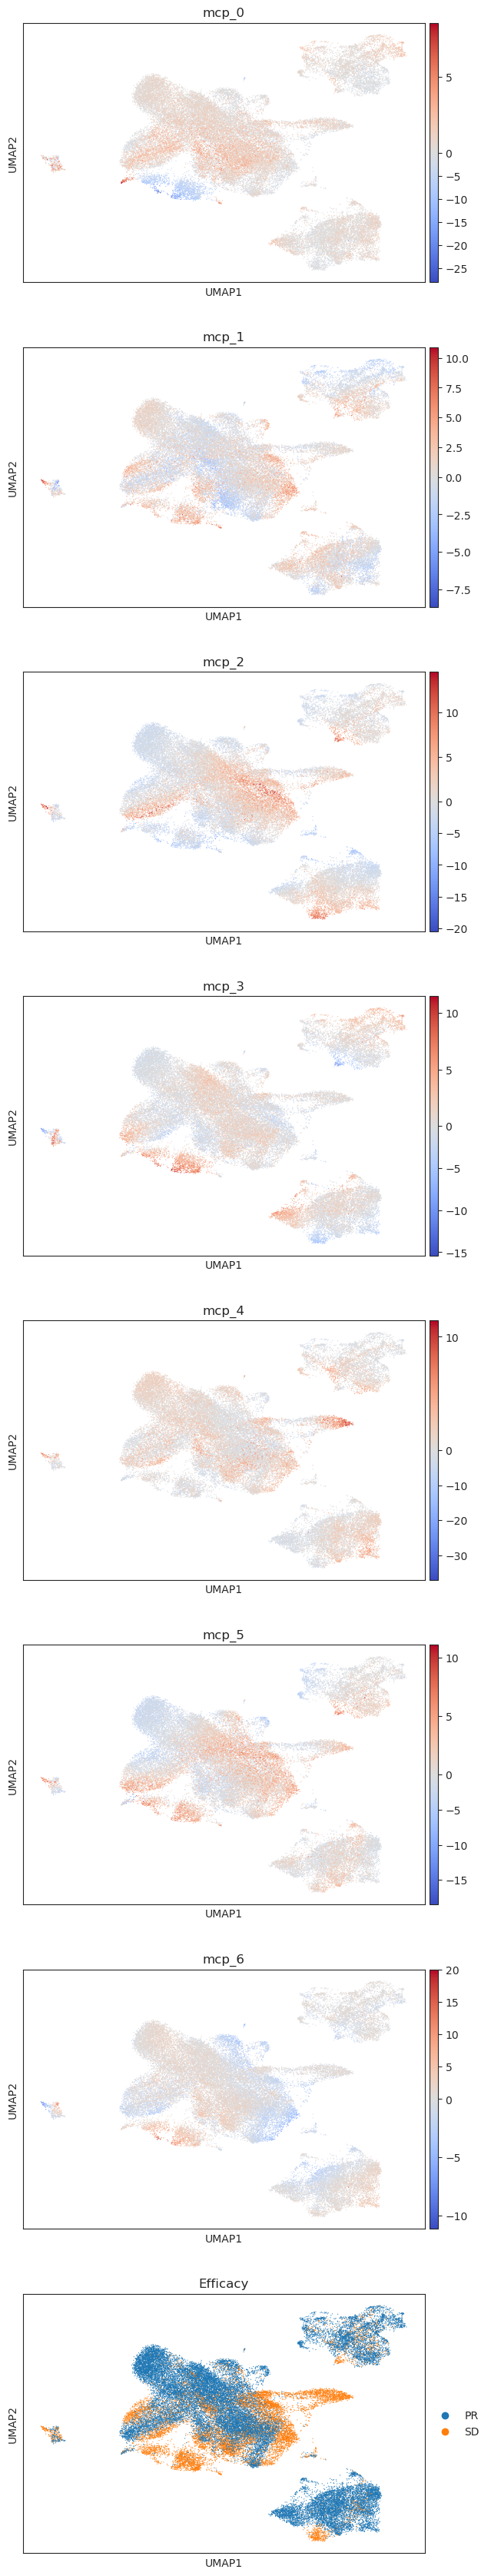

In [48]:
sc.pl.umap(adata_bs, color=["mcp_0", "mcp_1", "mcp_2","mcp_3","mcp_4","mcp_5","mcp_6","Efficacy"], ncols=1, cmap='coolwarm', vcenter=0)